<a href="https://colab.research.google.com/github/MarcusGitAccount/C-Markup-Language/blob/master/notebooks/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Link to google drive for storing the network weights and access the dataset

from google.colab import files
from google.colab import drive

DRIVE_BASE = "/content/gdrive/My Drive"
ON_COLAB = True

In [ ]:
if ON_COLAB:
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


Download Cityscapes from their own website

In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=USERNAME&password=PASSWORD&submit=Login' https://www.cityscapes-dataset.com/login/

--2020-12-05 20:33:43--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2020-12-05 20:33:45--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [  <=>               ]  43.07K   141KB/s    in 0.3s    

2020-12-05 20:33:46 (141 KB/s) - ‘index.html’ saved [44099]



In [ ]:
# Download fine annotations
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2020-12-05 20:37:49--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: ‘gtFine_trainvaltest.zip.2’

gtFine_trainvaltest 100%[===================>] 240.87M  19.4MB/s    in 14s     

2020-12-05 20:38:04 (17.3 MB/s) - ‘gtFine_trainvaltest.zip.2’ saved [252567705/252567705]



In [ ]:
# Download the 5000 images subsample
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2020-12-05 20:38:04--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11592327197 (11G) [application/octet-stream]
Saving to: ‘leftImg8bit_trainvaltest.zip.1’

leftImg8bit_trainva 100%[===================>]  10.80G  19.1MB/s    in 10m 4s  

2020-12-05 20:48:10 (18.3 MB/s) - ‘leftImg8bit_trainvaltest.zip.1’ saved [11592327197/11592327197]



In [ ]:
! unzip -q gtFine_trainvaltest.zip -d /content/gdrive/My\ Drive/datasets/Cityscapes/fine_annotations

In [ ]:
!  sudo apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (276 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package rar.
(Reading database ... 144865 files and directories currently installed

In [ ]:
!  unzip -q leftImg8bit_trainvaltest.zip.1 -d /content/gdrive/My\ Drive/datasets/Cityscapes/reduced_5000_images

Or download the Kaggle minified pairs

In [ ]:
! touch kaggle.json
! echo '{"username":"marcuspop","key":"8b381c5b1534ced92f9595763f97fda9"}' > kaggle.json

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! ls -la ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Dec  5 20:31 .
drwx------ 1 root root 4096 Dec  5 20:31 ..
-rw------- 1 root root   66 Dec  5 20:31 kaggle.json


In [ ]:
! kaggle datasets download -d dansbecker/cityscapes-image-pairs

 99% 199M/202M [00:03<00:00, 72.0MB/s]
100% 202M/202M [00:03<00:00, 60.2MB/s]


In [ ]:
! rm -rf data
! unzip -qq /content/cityscapes-image-pairs.zip -d data

In [ ]:
! ls -l data/cityscapes_data/train | wc -l
! ls -l data/cityscapes_data/val | wc -l

2976
501


UNet implementation
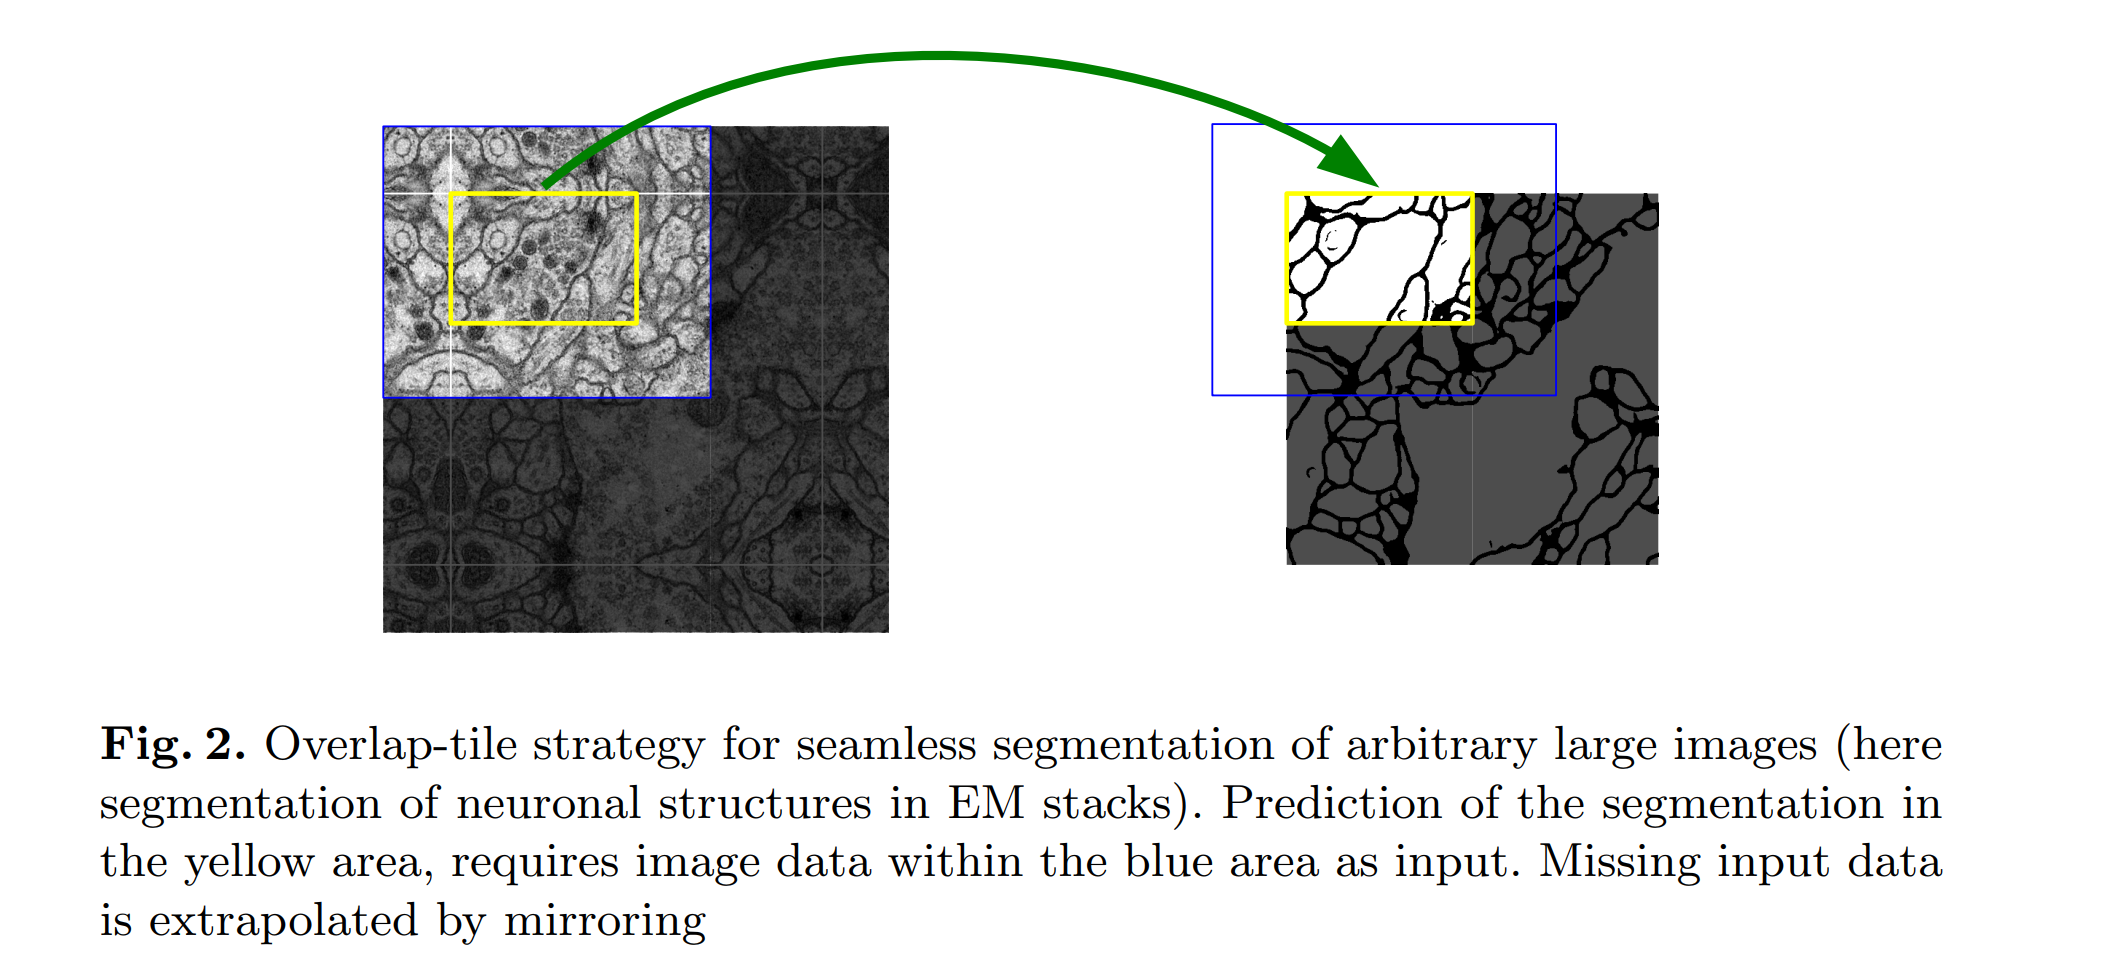

The network uses only valid convolutions(kernels use no additional padding). That makes the output smaller that the input. This is useful for the overlaping tile strategy used to segment large images.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from collections import namedtuple

This implementation makes use of cropping the input image in order for the network to be agnostic with regards to the input size, but it does not overlap them.

*Same padding* is also used instead of valid convolutions.

In [ ]:
ConvBlockOutput = namedtuple('ConvBlockOutput', ['activ', 'out'])

**Convolution block** used primarily in the contractig path in UNet

**Dropout** is not added by default

Returns a tuple consisting of the activations and maxpooled outputs

In [ ]:
def conv_block(input, filter_count, size=3, padding='same', pooling_size=2, initializer="he_normal"):
    x = Conv2D(filters=filter_count, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filter_count, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    pooled = MaxPooling2D(pool_size=(pooling_size, pooling_size))(x)
    return ConvBlockOutput(x, pooled)

**Expansive path deconvolution**

Upsampling, followed by a convolution. The results is then merged
with the activation output of the adjacent symmetric convolution
block in the contracting path. After this, we follow with another conv
block.

In [ ]:
from tensorflow.keras.layers import concatenate, UpSampling2D


def deconv_block(input, contracting_activ, filter_count, size=2, padding='same', strides=(2, 2)):
  x = UpSampling2D(size=(2, 2))(input)
  x = Conv2D(filters=filter_count, kernel_size=(size, size), padding=padding)(x)
  # Skip connection with the given conv activation. 
  # Used so we can learn to assemble a more precise output
  x = concatenate([x, contracting_activ])

  # Ignore the pooling part of the tuple
  x, _ = conv_block(input=x, size=size, padding=padding, filter_count=filter_count)
  return x

Assembling the endcoder-decoder UNet architecture.

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import SGD

# Putting it all together
# filter_count: Initial number of filters for the first convolution block
#               This is double for each block as we go down further in the
#               contracting path and viceversa for the decoder.
# Returns the assembled network
def UNet(input_shape, filter_count, class_count):
  input = Input(shape=input_shape)

  # Contracting path
  conv1, out = conv_block(input=input, filter_count=filter_count * 1)
  conv2, out = conv_block(input=out,   filter_count=filter_count * 2)
  conv3, out = conv_block(input=out,   filter_count=filter_count * 4)
  conv4, out = conv_block(input=out,   filter_count=filter_count * 8)
  out = Dropout(.5)(out)

  # If we use max pooling on the 5th block too we will not have matched
  # sizes when concatenating
  conv5, _ = conv_block(input=out, filter_count=filter_count * 16)
  out = Dropout(.5)(conv5)

  # Expanding path
  deconv1 = deconv_block(input=out,     contracting_activ=conv4, filter_count=filter_count * 8)
  deconv2 = deconv_block(input=deconv1, contracting_activ=conv3, filter_count=filter_count * 4)
  deconv3 = deconv_block(input=deconv2, contracting_activ=conv2, filter_count=filter_count * 2)
  deconv4 = deconv_block(input=deconv3, contracting_activ=conv1, filter_count=filter_count * 1)

  # 1D convolution to merge all channels into one
  output = Conv2D(filters=class_count, kernel_size=(1, 1))(deconv4)
  output = BatchNormalization()(output)
  output = softmax(output)

  model = Model(input, output)
  return model

Label data from https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py


In [ ]:
from collections import namedtuple

Label = namedtuple('Label', ['name', 'color'])


labels = [
    Label(  'unlabeled'           ,   (  0,   0,   0) ),
    Label(  'dynamic'             ,   (111,  74,   0) ),
    Label(  'ground'              ,   ( 81,   0,  81) ),
    Label(  'road'                ,   (128,  64, 128) ),
    Label(  'sidewalk'            ,   (244,  35, 232) ),
    Label(  'parking'             ,   (250, 170, 160) ),
    Label(  'rail track'          ,   (230, 150, 140) ),
    Label(  'building'            ,   ( 70,  70,  70) ),
    Label(  'wall'                ,   (102, 102, 156) ),
    Label(  'fence'               ,   (190, 153, 153) ),
    Label(  'guard rail'          ,   (180, 165, 180) ),
    Label(  'bridge'              ,   (150, 100, 100) ),
    Label(  'tunnel'              ,   (150, 120,  90) ),
    Label(  'pole'                ,   (153, 153, 153) ),
    Label(  'polegroup'           ,   (153, 153, 153) ),
    Label(  'traffic light'       ,   (250, 170,  30) ),
    Label(  'traffic sign'        ,   (220, 220,   0) ),
    Label(  'vegetation'          ,   (107, 142,  35) ),
    Label(  'terrain'             ,   (152, 251, 152) ),
    Label(  'sky'                 ,   ( 70, 130, 180) ),
    Label(  'person'              ,   (220,  20,  60) ),
    Label(  'rider'               ,   (255,   0,   0) ),
    Label(  'car'                 ,   (  0,   0, 142) ),
    Label(  'truck'               ,   (  0,   0,  70) ),
    Label(  'bus'                 ,   (  0,  60, 100) ),
    Label(  'caravan'             ,   (  0,   0,  90) ),
    Label(  'trailer'             ,   (  0,   0, 110) ),
    Label(  'train'               ,   (  0,  80, 100) ),
    Label(  'motorcycle'          ,   (  0,   0, 230) ),
    Label(  'bicycle'             ,   (119,  11,  32) ),
    Label(  'license plate'       ,   (  0,   0, 142) ),
]

In [ ]:
import os
import logging

train_path_img = f'{DRIVE_BASE}/datasets/Cityscapes/reduced_5000_images/leftImg8bit/train'
# The actual test folder has no segmentation masks
test_path_img =  f'{DRIVE_BASE}/datasets/Cityscapes/reduced_5000_images/leftImg8bit/val'
train_path_mask =  f'{DRIVE_BASE}/datasets/Cityscapes/fine_annotations/gtFine/train'
test_path_mask =  f'{DRIVE_BASE}/datasets/Cityscapes/fine_annotations/gtFine/val'

# Redundant, will compose a batch from image crops
# batch_size = 32
classes_num = len(labels)
in_height = 256
in_width = 256
img_height = 1024
img_width = 2048
#train_size = len(os.listdir(train_path))
#test_size = len(os.listdir(test_path))

checkpoint_path = f'{DRIVE_BASE}/models/unet.weights'
logging_path = f'{DRIVE_BASE}/models/logs'

In [ ]:
  logging.basicConfig(level=logging.INFO)
  logger = logging.getLogger('Notebook')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn as sns

# Split the image into crops that can be managed by the network
def loadAndSpliceImage(path, city, name, mapping_function=None):
  fname = os.path.join(path, city, name)
  return loadAndSpliceImage_(fname, mapping_function)

def loadAndSpliceImage_(path, mapping_function=None):
  img = np.array(Image.open(path).convert('RGB'))
  crops = []

  if mapping_function is not None:
    img = mapping_function(img)

  for h in range(0, img_height, in_height):
    for w in range(0, img_width, in_width):
      curr = img[h:h + in_height, w:w + in_width]
      crops.append(curr)

  crops = np.array(crops)
  return crops

In [ ]:
# Convert each RGB pixel in the segmentation mask to one hot encoding
def convertToOneHot(image):
  classes = len(labels)
  height, width = image.shape[:2]
  encoding = np.zeros((height, width, classes))

  for c in range(classes):
    encoding[:, :, c] = (image == np.array(labels[c].color)).all(2).astype(int)
  return encoding

In [ ]:
# Iterates the dataset in batches of given size and tuples of (image, mask)
def DatasetGenerator(img_path, mask_path):

  while True:
    for city in os.listdir(img_path):
      city_path = os.path.join(img_path, city)
      for img_name in os.listdir(city_path):
        mask_name = img_name[:-15] + 'gtFine_color.png'
        img_batch = loadAndSpliceImage(img_path, city, img_name)
        mask_batch = loadAndSpliceImage(mask_path, city, mask_name, convertToOneHot)

        yield img_batch, mask_batch

Writing a proper generator this time by extending the keras sequence generator

In [ ]:
# Initial testing for file indexing

dirs = os.listdir(train_path_img)
sizes = [len(os.listdir(os.path.join(train_path_img, dir))) for dir in dirs]
count = sum(sizes)
partial_sizes = [sizes[0]]

for i in range(1, len(sizes)):
  partial_sizes.append(partial_sizes[i - 1] + sizes[i])

print(partial_sizes, bisect_left(partial_sizes, 197))

[196, 291, 445, 589, 711, 820, 939, 1081, 1302, 1476, 1561, 1877, 1973, 2338, 2432, 2531, 2727, 2975] 1


In [ ]:
from tensorflow.keras.utils import Sequence
from bisect import bisect_left

class CustomgDatasetGenerator(Sequence):
  def __init__(self, img_path, mask_path):
    self.img_path = img_path
    self.mask_path = mask_path

    # City directories
    img_dirs = os.listdir(self.img_path)
    mask_dirs = os.listdir(self.img_path)
    self.dirs = list(set(img_dirs).intersection(mask_dirs))

    self.img_files = [os.listdir(os.path.join(img_path, dir)) for dir in self.dirs]
    self.mask_files = [[img[:-15] + 'gtFine_color.png' for img in img_dir] for img_dir in self.img_files]

    self.sizes = [len(dir) for dir in self.img_files]
    self.count = sum(self.sizes)
    # Partial sizes used in indexing each image using lower bound search
    self.partial_sizes = [self.sizes[0]]

    for i in range(1, len(self.sizes)):
      self.partial_sizes.append(self.partial_sizes[i - 1] + self.sizes[i])

    # PREDIFINED for Cityscapes for dataset images of (2048, 1024) and network input of (256, 256)
    self.slices = None
    self.slice_rows = 4
    self.slice_cols = 8
    self.img_width = 256
    self.img_height= 256
    self.slice_count = 32

  # Denotes the number of batches per epoch. In our case it' s the number of images
  # times the number of slices per image
  def __len__(self):
    return self.count * self.slice_count

  def getImageSlice(self, path, index, apply_func=None):
    img = np.array(Image.open(path).convert('RGB'))
    h = self.img_height
    w = self.img_width
    r = index // self.slice_cols
    c = index % self.slice_cols
    img = img[r * h:(r+1) * h, c * w:(c+1) * w]
    if apply_func:
      img = apply_func(img)
    # print(img.shape)
    return img.reshape((1,) + img.shape)

  # Generate one batch of data
  def __getitem__(self, index):
    # print(index)
    slice_index = index % self.slice_count
    index //= self.slice_count
    folder_index = bisect_left(self.partial_sizes, index + 1)
    file_index = index - (self.partial_sizes[folder_index - 1] if folder_index > 0 else 0)
    # print(slice_index, index, folder_index, file_index, self.partial_sizes,)

    img_name =  self.img_files[folder_index][file_index]
    mask_name = self.mask_files[folder_index][file_index]

    img_batch = self.getImageSlice(os.path.join(self.img_path, self.dirs[folder_index], img_name), slice_index)
    mask_batch = self.getImageSlice(os.path.join(self.mask_path, self.dirs[folder_index], mask_name), slice_index, apply_func=convertToOneHot)

    return img_batch, mask_batch

# Indexing testing
# g = CustomgDatasetGenerator(train_path_img, train_path_mask)
# for i in range(len(g)):
#   print(g[i])

In [ ]:
# Convert segmentation mask from one hot encoding to RGB
def fromOneHotToImage(mask):
  h, w = mask.shape[:2]
  result = np.zeros((h, w, 3))
  # colors = sns.color_palette("hls", classes_num)
  maxes = np.argmax(mask, axis=2)

  for c in range(classes_num):
    booleans = maxes == c

    result[:, :, 0] += booleans * labels[c].color[0]
    result[:, :, 1] += booleans * labels[c].color[1]
    result[:, :, 2] += booleans * labels[c].color[2]
  return result.astype(int)

def applyMaskOverImage(image, mask, lerp_coeff = 0.8):
  #masked_img = cv2.addWeighted(image / 255, .5, mask, 0.5, 0)
  return (image * lerp_coeff + mask * (1 - lerp_coeff)).astype(int)

Finding out that I cannot use the Kaggle set due to the color gradients in the minified mask image

In [ ]:
# name = os.listdir(train_path)[0]
# sample = np.array(Image.open(os.path.join(train_path, name)))
# mask = sample[:, 256:]
# hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
# hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
# color_count = np.unique(mask.reshape(-1, mask.shape[2]), axis=0).shape[0]
# plt.imshow(mask)
# print('Number of colors', color_count)

Trying to fix the gradient problem using K means clustering

In [ ]:
# from sklearn import cluster

# x, y, z = mask.shape
# mask_2d = mask.reshape(x * y, z)
# kmeans_clustering = cluster.KMeans(n_clusters = 7)
# kmeans_clustering.fit(mask_2d)

In [ ]:
# centers, labels = kmeans_clustering.cluster_centers_, kmeans_clustering.labels_
# new_mask = centers[labels].reshape(x, y, z)

In [ ]:
# mask_2d.shape

Testing implemented functions and data generator

(256, 256, 3) (256, 256, 3)


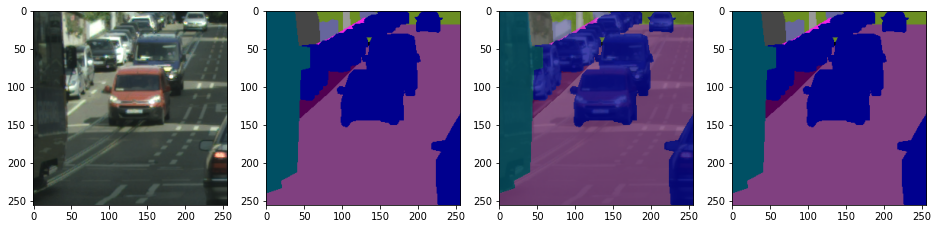

In [ ]:
crops_img = loadAndSpliceImage(train_path_img, 'stuttgart', 'stuttgart_000057_000019_leftImg8bit.png')
crops_mask = loadAndSpliceImage(train_path_mask, 'stuttgart', 'stuttgart_000057_000019_leftImg8bit.png'[:-15] + 'gtFine_color.png')

fig, ax = plt.subplots(1, 4, figsize=(16., 12.))

i = 11
print(crops_img[i].shape, crops_mask[i].shape)
mask = convertToOneHot(crops_mask[i])

ax[0].imshow(crops_img[i])
ax[1].imshow(crops_mask[i])

masked = applyMaskOverImage(crops_img[i], crops_mask[i], .25)
ax[2].imshow(masked)

back_again = fromOneHotToImage(mask)
ax[3].imshow(back_again)

Network instance

In [ ]:
model = UNet(input_shape=(in_height, in_width, 3), filter_count=64, class_count=classes_num)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

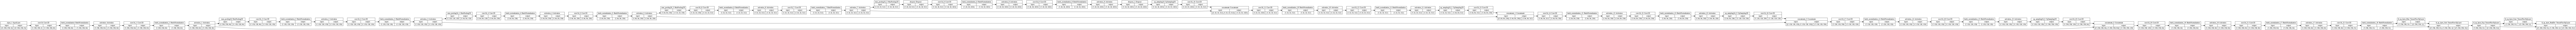

In [ ]:
tf.keras.utils.plot_model(model, 
                          show_layer_names=True, 
                          show_shapes=True,
                          rankdir="LR",
                          dpi=64)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
             # Reduce learning rate when loss is no longer improving much
             ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, cooldown=3, min_lr=1e-5, verbose=1),
             # Stop learning rate when loss has stopped improving
             EarlyStopping(monitor='loss', min_delta=1e-3, patience=15, verbose=1, mode='min'),
             ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='max')
]

Defining the loss function: Dice Coefficient (F1 Score)
- positively correlated to IOU(is ones predicts A is better so does the other)
- more suited for heavility imbalanced data than raw pixel accuracy

=  2 * the *Area of Overlap* **divided** by the* total number of pixels in both images*

In [ ]:
from tensorflow import reduce_mean, reduce_sum

def dice_coef(y_true, y_pred, smooth=1):
  axis = [1, 2, 3]
  intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
  union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
  dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
  return dice

Could not find the learning rate in the paper

A very large momentum is used to take into consideration the previous samples more.

In [ ]:
optimizer = SGD(lr=1e-4, momentum=0.99, name='UNet')
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef])

In [ ]:
train_generator = CustomgDatasetGenerator(train_path_img, train_path_mask)
validation_generator = CustomgDatasetGenerator(test_path_img, test_path_mask)

In [ ]:
train_generator[120][0].shape, train_generator[120][1].shape

((1, 256, 256, 3), (1, 256, 256, 31))

Model training:
- **steps_per_epoch** represent the number of batch iterations before a training epoch is considered finished(can be skipped if training on the whole dataset)

In [ ]:
model.fit(train_generator, 
          steps_per_epoch=1000, 
          validation_steps=100, 
          epochs=5,
          validation_data=validation_generator, 
          verbose=1, callbacks=callbacks)

Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.1613 - dice_coef: 0.0368
Epoch 00001: loss did not improve from 0.16481
1000/1000 [==============================] - 798s 798ms/step - loss: 0.1613 - dice_coef: 0.0368 - val_loss: 0.1635 - val_dice_coef: 0.0447
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.1559 - dice_coef: 0.0413
Epoch 00002: loss did not improve from 0.16481
1000/1000 [==============================] - 632s 632ms/step - loss: 0.1559 - dice_coef: 0.0413 - val_loss: 0.1529 - val_dice_coef: 0.0542
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.1526 - dice_coef: 0.0451
Epoch 00003: loss did not improve from 0.16481
1000/1000 [==============================] - 503s 503ms/step - loss: 0.1526 - dice_coef: 0.0451 - val_loss: 0.1528 - val_dice_coef: 0.0612
Epoch 4/5
1000/1000 [==============================] - ETA: 0s - loss: 0.1479 - dice_coef: 0.0500
Epoch 00004: loss did not improve from 0.16481
100

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(validation_generator, steps=200)

200/200 [==============================] - 43s 214ms/step - loss: 0.1449 - dice_coef: 0.0782


[0.14485731720924377, 0.07816875725984573]

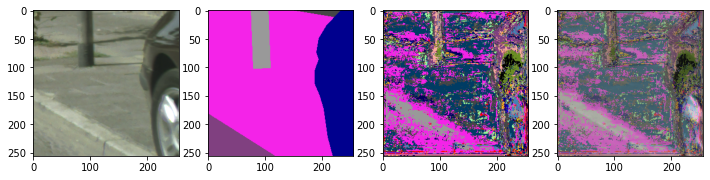

In [ ]:
img, mask = validation_generator[3190]
pred = model.predict(img)

img = img[0]
mask = fromOneHotToImage(mask[0])
pred = fromOneHotToImage(pred[0])

fig, ax = plt.subplots(1, 4, figsize=(12., 9.))

ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(applyMaskOverImage(img, pred, .5))

Full image prediction

In [ ]:
def rebuildCropped(crops):
  return np.vstack([
            np.hstack(crops[0:8]),
            np.hstack(crops[8:16]),
            np.hstack(crops[16:24]),
            np.hstack(crops[24:32])
  ])

def predictCropped(model, crops_img, crops_mask):
  n = crops_img.shape[0]
  predictions = np.vstack([model.predict(crops_img[0].reshape(1, 256, 256, 3)) for i in range(n)])

  img = rebuildCropped(crops_img)
  mask = fromOneHotToImage(rebuildCropped(crops_mask))
  pred = fromOneHotToImage(rebuildCropped(predictions))

  fig, ax = plt.subplots(1, 4, figsize=(12., 9.))

  ax[0].imshow(img)
  ax[1].imshow(mask)
  ax[2].imshow(pred)
  ax[3].imshow(applyMaskOverImage(img, pred, .35))

In [ ]:
crops_img = loadAndSpliceImage(train_path_img, 'stuttgart', 'stuttgart_000057_000019_leftImg8bit.png')
crops_mask = loadAndSpliceImage(train_path_mask, 'stuttgart', 'stuttgart_000057_000019_leftImg8bit.png'[:-15] + 'gtFine_color.png')

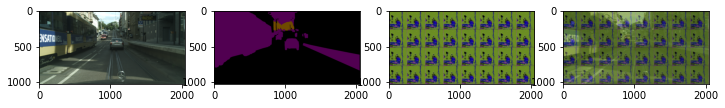

In [ ]:
predictCropped(model, crops_img, crops_mask)